In [ ]:
# EXECUTAR NO TERMINAL:

# !pip install pandas
# !pip install tensorflow
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib

## BIBLIOTECAS

In [1]:
# Bibliotecas para data-science
import pandas as pd   #Biblioteca para Dataframes
import os   #Biblioteca para acesso dos arquivos
import glob   #Biblioteca para acesso dos arquivos
import numpy as np  #Biblioteca numérica

# Bibliotecas para problemas de otimização
import pyomo.environ as pyo  #Biblioteca para otimização
from amplpy import AMPL

# Bibliotecas para redes neurais
import tensorflow as tf
import h5py
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras import backend as K  #Função para resetar a rede criada

# Bibliotecas gráficas
import matplotlib.pyplot as plt  #Biblioteca para plotar gráfico
from mpl_toolkits.mplot3d import Axes3D #Função para gerar gráfico 3D
from matplotlib.lines import Line2D #Função para gerar a legenda do gráfico com dois eixos Y

# Bibliotecas para medição de tempo
import time

# Possíveis bibliotecas úteis:
import sympy as sp   #Biblioteca simbólica
import scipy as scp  #Biblioteca matemática geral

# PANDAS


## Código Principal

### Definição das Variáveis

Base

In [2]:
# DETERMINAÇÃO DAS TABELAS DA ONS

dir = "G:\\Meu Drive\\Dissertação Yuri\\Dados ONS"


ons = {}
ons_usinas = {}

#Acessar o drive e armazenar os dados
for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
  if len(list(set(os.listdir(f'{dir}\\{i}')) - {'desktop.ini'})) == 1:
    ons[i] = pd.read_csv(glob.glob(f'{dir}\\{i}\\*')[0], delimiter = ";")
  else:
    ons[i] = None

# Concatenar e armazenar os dados disponibilizados de forma mensal
for i in ons.keys():
  tab_temp=[]
  if ons[i] is None:
    for j in range(1,13):
      if os.path.isfile(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv') == True:
        tab_temp.append(pd.read_csv(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv', delimiter = ";"))
        ons[str(i)] = pd.concat(tab_temp)
      else:
        pass
  else:
    pass

  del tab_temp

  #Separação em usinas térmicas
  ons[i] = ons[i].loc[ons[i]['nom_tipousina']=='TÉRMICA']
  ons_usinas[i] = list(set(ons[i]['nom_usina'].values.tolist()))

  #Remover colunas desnecessárias
  ons[i] = ons[i].drop(columns=['id_subsistema',
                          'nom_subsistema',
                          'nom_estado',
                          'cod_modalidadeoperacao',
                          'nom_tipousina',
                          'ceg'])

  #Trocar o nome das colunas restantes
  ons[i] = ons[i].rename(columns={'din_instante':'Dia-Hora',
                            'id_estado':'Estado',
                            'nom_tipocombustivel':'Combustível',
                            'nom_usina':'Usina',
                            'val_geracao':'Geração'})

############################################################################################################

# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0,1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
  iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
  iema_ger_usinas[i] = list(iema[i][0]['Usina'])
  iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i,j,dir,arq):
  if os.path.exists(dir):
    if os.path.isfile(f'{dir}/{arq}') == False:
      ons[i].loc[ons[i]['Usina']==ons_usinas[i][j]].to_csv(f'{dir}/{arq}',index=False)
  else:
    os.makedirs(f'{dir}')
    ons[i].loc[ons[i]['Usina']==ons_usinas[i][j]].to_csv(f'{dir}/{arq}',index=False)

for i in ons:
  if i in iema_emi_usinas.keys(): # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
    for j in range(len(ons_usinas[i])):
      if ons_usinas[i][j] in iema_emi_usinas[i]:
        dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas[i][j]}\\Dados de Geração'
        arq = f'{ons_usinas[i][j]}_{i}.csv'
        armazenar(i,j,dir,arq)


dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

#COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

#Gás Natural e Ciclo Combinado
#Gás Natural e Ciclo Brayton
#Gás Natural e Motor Combustão

#Carvão Mineral e Ciclo Rankine

#Óleo Combustível e Motor Combustão

#Óleo Diesel e Motor Combustão
#Óleo Diesel e Ciclo Combinado

#############################################################################################################

### Otimização - AMPL

Base

In [3]:
def ampl_model(iema_ampl,ons_ampl):
  # Criando uma instância AMPL
  ampl_instance = AMPL()

  # Definindo parâmetros
  PG = list(ons_ampl['Geração']) #(dividir por 100 para PU)
  E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

  # Definindo o modelo em AMPL
  ampl_instance.eval(r'''
    set intervalos;

    param PG{intervalos};
    param E; # Emissão anual

    var alfa >= 0;
    var beta >= 0;
    var gamma >= 0;
    var omega >= 0;
    var mi >= 0;

    minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; 
  ''')
# minimize MSRE: sqrt(1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2)    # MAPE -> Root Mean Squared Error (dividir por 100 para PU)
# minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2           # MSE  -> Mean Squared Error (dividir por 100 para PU)
# minimize MAPE: (1/card(intervalos) * sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k]) - E) / E )*100   # MAPE -> Mean Absolute Percentage Error (dividir por 100 para PU)
  ampl_instance.set['intervalos'] = range(0,len(PG))
  ampl_instance.param['PG'] = PG
  ampl_instance.param['E'] = E

  # Carregando o modelo
  ampl_instance.setOption('solver','C:\\Users\\Yuri_\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
  ampl_instance.solve() 

  # Extraindo resultados
  alfa = ampl_instance.getVariable("alfa").value()
  beta = ampl_instance.getVariable("beta").value()
  gamma = ampl_instance.getVariable("gamma").value()
  omega = ampl_instance.getVariable("omega").value()
  mi = ampl_instance.getVariable("mi").value()

  #Salvando os resultados
  tab = pd.DataFrame({'Coeficientes':['Alfa','Beta','Gamma','Omega','Mi'],'Valores':[alfa,beta,gamma,omega,mi]})
  tab.to_csv(f'{dir2}\\{list(ons_ampl['Usina'])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv',index=False)

  #Limpando o modelo para disponibilizar armazenamento na memória
  del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'   # MW / PU  (ALTERAR A FUNÇÃO OBJETIVO)

###############################################################################################################################


# Código para somar os dados de emissão IEMA
dir_iema = f'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA' 
ano = os.listdir(f'{dir_iema}')[0]
iema_ampl = iema[ano][1]
for i in iema.keys():
  if str(int(i)+1) in iema.keys():
    iema_ampl = pd.merge(iema_ampl,iema[str(int(i)+1)][1],how='outer',on='Usina',suffixes=(f'_{i}', f'_{str(int(i)+1)}'))
    iema_ampl.replace(np.nan,0,inplace=True)
    data = {'Usina': iema_ampl['Usina'].tolist(),'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i)+1)}']).tolist()}
    iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
  ons_ampl = pd.concat(map(pd.read_csv, glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv'))) # Código para concatenar os dados de geração ONS
  if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
    ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]   #DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
  if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
    dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
    if os.path.exists(dir2):
      if os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == False:
        ampl_model(iema_ampl,ons_ampl)
    else:
      os.makedirs(f'{dir2}')
      ampl_model(iema_ampl,ons_ampl)

In [3]:
ampl=AMPL()

### Criação das Emissões Sintéticas

Base

In [4]:
# CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS ANOS APRESENTADOS NO IEMA

def em_sint(j,arq):
  PG = list(arq['Geração'])
  em = []

  dir2 = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Coeficientes\\AMPL\\Dados Concatenados'
  if os.path.isfile(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == True:
    tab = pd.read_csv(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')

    alfa = tab['Valores'].loc[tab['Coeficientes'] == 'Alfa'].item()
    beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
    gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
    omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
    mi = tab['Valores'].loc[tab['Coeficientes'] == 'Mi'].item()

    for k in range(len(PG)):
      em.append((alfa * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mi * PG[k]))

    data={
      'Dia-Hora': list(arq['Dia-Hora']),
      'Combustível': list(arq['Combustível']),
      'Usina': list(arq['Usina']),
      'Emissão': em
    }

    df = pd.DataFrame(data)
    df.to_csv(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv',index=False)


zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'   # MW / PU

for i in ons:
  if i in iema_emi_usinas.keys():
    for j in range(len(usinas)):
      if usinas[j] in iema_emi_usinas[i]:
        arq = ons[i].loc[ons[i]['Usina']==usinas[j]]
        if arq.empty == False:
          dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Dados de Emissão (Sintético)\\AMPL\\{i}'
          if os.path.exists(dir):
            if os.path.isfile(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == False:
              em_sint(j,arq)
          else:
            os.makedirs(f'{dir}')
            em_sint(j,arq)

### Tratamento dos Dados - Geral

Base

In [6]:
temp = []
for i in usinas:
  dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{i}\\Dados de Geração'
  for j in iema.keys():
    if os.path.isfile(f'{dir}\\{i}_{j}.csv'):
      temp.append(pd.read_csv(f'{dir}\\{i}_{j}.csv'))
      tab_temp = pd.concat(temp)

temp = []
for i in iema:
    temp.append(iema[i][1])
    iema_temp = pd.concat(temp)

iema_temp = iema_temp.drop_duplicates(subset='Usina')

temp = pd.merge(tab_temp,iema_temp,how='left',on='Usina')

data = {
    'Usina':temp['Usina'],
    'Geração':temp['Geração'],
    'Combustível':temp['Combustível_x'],
    'Ciclo de Operação':temp['Ciclo de Operação'],
    'Potência Instalada': temp['Potência Instalada (MW)']
}

temp = pd.DataFrame(data)
temp = temp.dropna(subset='Ciclo de Operação')

ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),['Combustível','Ciclo de Operação'])],remainder='passthrough')
x=ct.fit_transform(temp)

colunas = ['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Usina','Geração','Potência Instalada']

tab_trat = pd.DataFrame(x,columns=colunas)

### Tratamento dos Dados - Específico

Base

In [8]:
usina = input('Insira a usina a ser analisada:')  #Para utilizar os dados de todas as usinas, deixar em branco
zeros = 'com_zeros'

usina_serie = tab_trat['Usina']
#tab_trat_usina = tab_trat.loc[tab_trat['Usina'] == usina]

temp = []
if usina == '':
    for i in usinas:
        dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{i}\\Dados de Emissão (Sintético)\\AMPL'
        for j in iema.keys():
            if os.path.isfile(f'{dir}\\{j}\\{i}_MSE_MW_{zeros}.csv'):
                temp.append(pd.read_csv(f'{dir}/{j}/{i}_MSE_MW_{zeros}.csv'))
                emi = pd.concat(temp)
else:
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Dados de Emissão (Sintético)\\AMPL'
    for i in iema.keys():
        if os.path.isfile(f'{dir}/{i}/{usina}_MSE_MW_{zeros}.csv'):
            temp.append(pd.read_csv(f'{dir}/{i}/{usina}_MSE_MW_{zeros}.csv'))
            emi = pd.concat(temp)


x = tab_trat[['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Geração','Potência Instalada']]

# Definição das variáveis de treino e teste
sc = StandardScaler() # Transforma variáveis categóricas em numéricas
x = sc.fit_transform(x)
x = pd.DataFrame({'Coluna1': x[:, 0], 'Coluna2': x[:, 1], 'Coluna3': x[:, 2], 'Coluna4':x[:, 3], 'Coluna5':x[:, 4], 'Coluna6':x[:, 5], 'Coluna7':x[:, 6], 'Coluna8':x[:, 7], 'Geração':x[:, 8], 'Potência Instalada':x[:, 9], 'Usina':usina_serie})
x = x.loc[x['Usina'] == usina] if usina != '' else x
x = x.drop(['Usina'],axis=1)

y = emi['Emissão']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

ValueError: Found input variables with inconsistent numbers of samples: [1460616, 1459872]

Teste 1

In [33]:
usina = input('Insira a usina a ser analisada:')  # Para utilizar os dados de todas as usinas, deixar em branco
zeros = 'com_zeros'

usina_serie = tab_trat['Usina']
#tab_trat_usina = tab_trat.loc[tab_trat['Usina'] == usina]

temp = []
if usina == '':
    for i in usinas:
        dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{i}\\Dados de Emissão (Sintético)\\AMPL'
        for j in iema.keys():
            if os.path.isfile(f'{dir}\\{j}\\{i}_MAPE_MW_{zeros}.csv'):
                temp.append(pd.read_csv(f'{dir}/{j}/{i}_MAPE_MW_{zeros}.csv'))
    emi = pd.concat(temp) if temp else pd.DataFrame(columns=['Emissão'])
else:
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Dados de Emissão (Sintético)\\AMPL'
    for i in iema.keys():
        if os.path.isfile(f'{dir}/{i}/{usina}_MAPE_MW_{zeros}.csv'):
            temp.append(pd.read_csv(f'{dir}/{i}/{usina}_MAPE_MW_{zeros}.csv'))
    emi = pd.concat(temp) if temp else pd.DataFrame(columns=['Emissão'])

# Verifique se há dados em 'emi'
if emi.empty:
    print(f"Não foram encontrados dados de emissão para a usina '{usina}'")
else:
    x = tab_trat[['ohe1', 'ohe2', 'ohe3', 'ohe4', 'ohe5', 'ohe6', 'ohe7', 'ohe8', 'Geração', 'Potência Instalada']]

    # Definição das variáveis de treino e teste
    sc = StandardScaler()  # Transforma variáveis categóricas em numéricas
    x = sc.fit_transform(x)
    x = pd.DataFrame({
        'Coluna1': x[:, 0], 'Coluna2': x[:, 1], 'Coluna3': x[:, 2], 'Coluna4': x[:, 3],
        'Coluna5': x[:, 4], 'Coluna6': x[:, 5], 'Coluna7': x[:, 6], 'Coluna8': x[:, 7],
        'Geração': x[:, 8], 'Potência Instalada': x[:, 9], 'Usina': usina_serie
    })
    x = x.loc[x['Usina'] == usina] if usina != '' else x
    x = x.drop(['Usina'], axis=1)

    # Certifique-se de que x e y tenham o mesmo número de amostras
    min_len = min(len(x), len(emi))
    x = x.iloc[:min_len]
    y = emi['Emissão'].iloc[:min_len]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

    print("Dados preparados com sucesso!")

Dados preparados com sucesso!


Teste 2 (Com Alinhamento)

In [10]:
usina = input('Insira a usina a ser analisada:')  # Para utilizar os dados de todas as usinas, deixar em branco
zeros = 'com_zeros'

usina_serie = tab_trat['Usina']
temp = []

# Função para carregar os dados de emissão
def carregar_dados_emissao(usina, iema_keys, zeros):
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Dados de Emissão (Sintético)\\AMPL'
    temp_usina = []
    for i in iema_keys:
        file_path = f'{dir}\\{i}\\{usina}_MSE_MW_{zeros}.csv'
        if os.path.isfile(file_path):
            temp_usina.append(pd.read_csv(file_path))
    return temp_usina

# Carregar dados de emissão
if usina == '':
    for i in usinas:
        temp.extend(carregar_dados_emissao(i, iema.keys(), zeros))
else:
    temp.extend(carregar_dados_emissao(usina, iema.keys(), zeros))

if not temp:
    raise ValueError("Nenhum arquivo de emissão encontrado.")

emi = pd.concat(temp, ignore_index=True)

x = tab_trat[['ohe1', 'ohe2', 'ohe3', 'ohe4', 'ohe5', 'ohe6', 'ohe7', 'ohe8', 'Geração', 'Potência Instalada']]

# Transformar variáveis categóricas em numéricas
sc = StandardScaler()
x_scaled = sc.fit_transform(x)
x_scaled = pd.DataFrame({'Coluna1': x_scaled[:, 0], 'Coluna2': x_scaled[:, 1], 'Coluna3': x_scaled[:, 2], 
                         'Coluna4': x_scaled[:, 3], 'Coluna5': x_scaled[:, 4], 'Coluna6': x_scaled[:, 5], 
                         'Coluna7': x_scaled[:, 6], 'Coluna8': x_scaled[:, 7], 'Geração': x_scaled[:, 8], 
                         'Potência Instalada': x_scaled[:, 9], 'Usina': usina_serie})

# Filtrar pelos dados da usina específica, se aplicável
if usina != '':
    x_scaled = x_scaled.loc[x_scaled['Usina'] == usina]

x_scaled = x_scaled.drop(['Usina'], axis=1)

# Garantir que 'emi' tenha a mesma quantidade de amostras que 'x_scaled'
if len(x_scaled) != len(emi):
    print(f"Antes do alinhamento: x({len(x_scaled)}), y({len(emi)})")
    # Alinhar os índices dos DataFrames
    x_scaled, emi = x_scaled.align(emi, join='inner', axis=0)
    print(f"Depois do alinhamento: x({len(x_scaled)}), y({len(emi)})")

y = emi['Emissão']

# Dividir os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, shuffle=False)


Antes do alinhamento: x(1460616), y(1459872)
Depois do alinhamento: x(1459872), y(1459872)


### Criação Rede Neural

Base

In [11]:
K.clear_session()   #Limpar redes geradas anteriormente
rede = tf.keras.Sequential()

if usina == '': #EM TESTE
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(1))

else:
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
rede.compile(optimizer=opt, loss='mean_squared_error')

### Treino e Execução da Rede Neural

Teste 1 - MSRE em Looping Infinito

In [72]:
import random
import time
import os
# Fixar sementes para reprodutibilidade
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Definição da métrica personalizada
class MeanSquaredRelativeError(tf.keras.metrics.Metric):
    def __init__(self, name='msre', **kwargs):
        super(MeanSquaredRelativeError, self).__init__(name=name, **kwargs)
        self.msre = self.add_weight(name='msre', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        relative_errors = tf.square((y_true - y_pred) / 
                                    tf.maximum(tf.abs(y_true), tf.keras.backend.epsilon()))
        mean_relative_errors = tf.reduce_mean(relative_errors)
        self.msre.assign(mean_relative_errors)

    def result(self):
        return self.msre

    def reset_states(self):
        self.msre.assign(0.0)

# Inicializa a métrica MSRE 
msre = MeanSquaredRelativeError()

# Enquanto para treinar a rede N vezes até atingir um erro satisfatório
tic = time.time()
i = 0
while True:
    i += 1
    rede.fit(x_train, y_train, epochs=2000, verbose=0)
    y_pred = rede.predict(x_train)
    msre.update_state(y_train, y_pred)
    msre_result = msre.result().numpy()

    print(f'MSRE Geração {i}: {msre_result}')
    
    msre.reset_states()  # Reseta o estado da métrica

    if msre_result < 20:  # Critério para interromper o treinamento
        tac = time.time()
        break

tempo_exec = tac - tic
print(f'\nTempo de Execução: {tempo_exec}')

# Salvar os pesos no diretório
if usina == '':
    dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
    rede.save_weights(f'{dir}\\{usina}.weights.h5')
else:
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Pesos'
    if os.path.exists(dir):
        if not os.path.isfile(f'{dir}\\{usina}.weights.h5'):
            rede.save_weights(f'{dir}\\{usina}.weights.h5')
    else:
        os.makedirs(f'{dir}')
        rede.save_weights(f'{dir}\\{usina}.weights.h5')

658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MSRE Geração 1: 96.61466217041016
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MSRE Geração 2: 96.79293060302734
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MSRE Geração 3: 96.60757446289062
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MSRE Geração 4: 96.14555358886719


KeyboardInterrupt: 

Teste 2 - Novamente em Looping Infinito

In [65]:
#Definição de Métricas Personalizadas

# Custom metric for MSRE
class MeanSquaredRelativeError(tf.keras.metrics.Metric):
    def __init__(self, name='msre', **kwargs):
        super(MeanSquaredRelativeError, self).__init__(name=name, **kwargs)
        self.msre = self.add_weight(name='msre', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        relative_errors = tf.square((y_true - y_pred) / 
                                    tf.maximum(tf.abs(y_true), tf.keras.backend.epsilon()))
        mean_relative_errors = tf.reduce_mean(relative_errors)
        self.msre.assign(mean_relative_errors)

    def result(self):
        return self.msre

    def reset_states(self):
        self.msre.assign(0.0)


# Inicializa as métricas MSRE 
msre = MeanSquaredRelativeError()

# Enquanto para treinar a rede N vezes até atingir um erro satisfatório
tic = time.time()
i = 0
while True:
    i += 1
    rede.fit(x_train,y_train,epochs=2000,verbose=0)
    y_pred = rede.predict(x_train)
    msre.update_state(y_train, y_pred)
    msre_result = msre.result().numpy()

    print(f'MSRE Geração {i}: {msre_result}')

     
    

    if msre_result < 20:  # Critério para interromper o treinamento
        tac = time.time()
        break

tempo_exec = tac - tic
print(f'\nTempo de Execução: {tempo_exec}')

# Salvar os pesos no diretório
if usina == '':
    dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
    rede.save_weights(f'{dir}\\{usina}.weights.h5')
    
else:
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Pesos'
    if os.path.exists(dir):
        if os.path.isfile(f'{dir}\\{usina}.weights.h5') == False:
            rede.save_weights(f'{dir}\\{usina}.weights.h5')
    else:
        os.makedirs(f'{dir}')
        rede.save_weights(f'{dir}\\{usina}.weights.h5')


658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MSRE Geração 1: 96.1824722290039
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
MSRE Geração 2: 96.19811248779297


KeyboardInterrupt: 

Base

In [12]:
# Inicializa a medição do erro quadrático médio MSE 
mse = tf.keras.metrics.MeanSquaredError()


# While para treinar a rede N vezes até atingir um erro satisfatório
tic = time.time()
i=0
while True:
    i+=1
    rede.fit(x_train,y_train,epochs=2000,verbose=0) #100 a 2000 epochs
    y_pred = rede.predict(x_train)

    mse.update_state(y_train, y_pred)
    mse_result = mse.result().numpy()
    print(f'MSE Geração {i}: {mse_result}')
    if mse_result < 20:
        tac = time.time()
        break
tempo_exec = tac - tic
print(f'\nTempo de Execução: {tempo_exec}')

#Salvar os pesos no diretório
if usina == '':
    dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
    
    rede.save_weights(f'{dir}\\Pesos_Geral.weights.h5')
else:
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Pesos'
    if os.path.exists(dir):
        if os.path.isfile(f'{dir}\\{usina}.weights.h5') == False:
            rede.save_weights(f'{dir}\\{usina}.weights.h5')
    else:
        os.makedirs(f'{dir}')
        rede.save_weights(f'{dir}\\{usina}.weights.h5')

36497/36497 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step
MSE Geração 1: 7277.857421875
36497/36497 ━━━━━━━━━━━━━━━━━━━━ 113s 3ms/step
MSE Geração 2: 7277.71875
36497/36497 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms/step
MSE Geração 3: 7278.01611328125


Teste 3 - MSRE (Erro de Dimensionalidade)

In [74]:
# Inicializa a medição do erro quadrático médio MSRE
msre = tf.keras.metrics.Mean()

# While para treinar a rede N vezes até atingir um erro satisfatório
max_iterations = 150 # limitar interações
max_execution_time = 4000  # 1 hour+
tic = time.time()
i = 0
while True:
    i += 1
    rede.fit(x_train, y_train, epochs=2000, verbose=0)
    y_pred = rede.predict(x_train)

    # Calculate MSRE
    relative_errors = tf.abs((y_train - y_pred) / y_train)
    squared_relative_errors = tf.square(relative_errors)
    flattened_squared_relative_errors = tf.keras.backend.flatten(squared_relative_errors)
    msre.update_state(flattened_squared_relative_errors)
    msre_result = tf.keras.backend.eval(msre.result())
    print(f'MSRE Geração {i}: {msre_result}')
    if msre_result < 20 or i >= max_iterations:
        tac = time.time()
        break

    if time.time() - tic > max_execution_time:
        print("Tempo de execução máximo alcançado. Parando o treinamento.")
        break

tempo_exec = tac - tic
print(f'\nTempo de Execução: {tempo_exec}')

# Save predictions and actual values
y_pred_list.append(y_pred)
y_train_list.append(y_train)

if msre_result < 20 or i >= max_iterations:
    break

# Salvar os pesos no diretório
if usina == '':
    dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
    
    rede.save_weights(f'{dir}\\Pesos_Geral.weights.h5')
else:
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Pesos'
    if os.path.exists(dir):
        if os.path.isfile(f'{dir}\\{usina}.weights.h5') == False:
            rede.save_weights(f'{dir}\\{usina}.weights.h5')
    else:
        os.makedirs(f'{dir}')
        rede.save_weights(f'{dir}\\{usina}.weights.h5')

658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


ValueError: Data must be 1-dimensional, got ndarray of shape (21043, 21043) instead

Teste 4 (Correção de Dimensão com Classe)

In [9]:
# Custom metric for MSRE
class MeanSquaredRelativeError(tf.keras.metrics.Metric):
    def __init__(self, name='msre', **kwargs):
        super(MeanSquaredRelativeError, self).__init__(name=name, **kwargs)
        self.msre = self.add_weight(name='msre', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        relative_errors = tf.square((y_true - y_pred) / 
                                    tf.maximum(tf.abs(y_true), tf.keras.backend.epsilon()))
        mean_relative_errors = tf.reduce_mean(relative_errors)
        self.msre.assign(mean_relative_errors)

    def result(self):
        return self.msre

    def reset_states(self):
        self.msre.assign(0.0)

# Inicializa a métrica personalizada MSRE
msre = MeanSquaredRelativeError()

# Parâmetros de treinamento
max_iterations = 50 # interações
epochs_per_iteration = 100 # 100 a 2000
max_execution_time = 1800  # 1 hour / 0.5h
tic = time.time()
i = 0

# Variáveis para salvar previsões e valores reais
y_pred_list = []
y_train_list = []

# Loop de treinamento
while True:
    i += 1
    # Treinamento da rede neural
    rede.fit(x_train, y_train, epochs=epochs_per_iteration, verbose=0)
    y_pred = rede.predict(x_train)

    # Garantir que y_pred e y_train tenham a mesma forma
    y_pred = np.reshape(y_pred, y_train.shape)

    # Atualizar e calcular MSRE
    msre.update_state(y_train, y_pred)
    msre_result = msre.result().numpy()
    print(f'MSRE Geração {i}: {msre_result}')
    
    # Resetar a métrica após cada cálculo para a próxima iteração
    msre.reset_states()

    # Verificar condições de parada
    if msre_result < 20 or i >= max_iterations:
        tac = time.time()
        break

    if time.time() - tic > max_execution_time:
        print("Tempo de execução máximo alcançado. Parando o treinamento.")
        tac = time.time()
        break

tempo_exec = tac - tic
print(f'\nTempo de Execução: {tempo_exec}')

# Save predictions and actual values
y_pred_list.append(y_pred)
y_train_list.append(y_train)

# Salvar os pesos no diretório
if usina == '':
    dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
else:
    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Pesos'

if not os.path.exists(dir):
    os.makedirs(dir)

weights_path = f'{dir}\\{usina if usina else "Geral"}.weights.h5'
rede.save_weights(weights_path)
print(f'Pesos salvos em: {weights_path}')

658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MSRE Geração 1: 0.0004982926766388118

Tempo de Execução: 223.16141653060913
Pesos salvos em: G:\Meu Drive\Dissertação Yuri\ONS Termeletricas\Aparecida\Pesos\Aparecida.weights.h5


### Execução da Rede à Partir de Pesos Salvos

Base

In [57]:
# Inicializa a medição do erro quadrático médio
mse = tf.keras.metrics.MeanSquaredError()

# Carregar os pesos
dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}/Pesos'
rede.load_weights(f'{dir}/{usina}.weights.h5')

# Executa a rede
y_pred = rede.predict(x_train)

mse.update_state(y_train, y_pred)
mse_result = mse.result().numpy()
print(f'MSE Geração {i}: {mse_result}')

658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAPE Geração 1: 28606796.0
MAPE Geração 1: 28606796.0


Teste 1 - Erro

In [10]:
# Inicializa a medição do erro quadrático médio
msre = MeanSquaredRelativeError()


# Carregar os pesos
dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}/Pesos'
rede.load_weights(f'{dir}/{usina}.weights.h5')

# Executa a rede
y_pred = rede.predict(x_train)

msre.update_state(y_train, y_pred)
msre_result = msre.result().numpy()
print(f'MSRE Geração {i}: {msre_result}')

658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MSRE Geração 1: 96.13847351074219


## Gráficos

### Gráficos 2D

Base

Regressão Aparecida (MSRE: 96.1385)


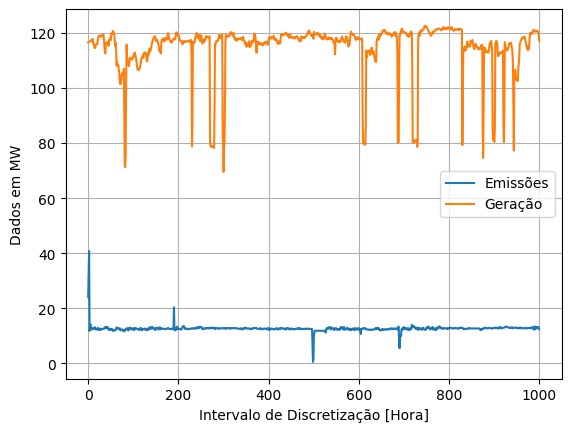

In [11]:
# Verifique se há dados suficientes para plotar
if len(y_test) > 0 and len(tab_trat['Geração'].loc[tab_trat['Usina'] == usina]) > 0:
    # Criação da variável x_fig
    x_fig = np.linspace(0, len(y_test), len(y_test))
    tempo_inicio = 0
    tempo_fim = min(1000, len(y_test), len(tab_trat['Geração'].loc[tab_trat['Usina'] == usina]))

    plt.figure()
    plt.plot(x_fig[tempo_inicio:tempo_fim], y_test[tempo_inicio:tempo_fim], 
             x_fig[tempo_inicio:tempo_fim], tab_trat['Geração'].loc[tab_trat['Usina'] == usina].values[tempo_inicio:tempo_fim])
    plt.legend(['Emissões', 'Geração'])
    plt.xlabel('Intervalo de Discretização [Hora]')
    plt.ylabel('Dados em MW')
    plt.grid()
    if usina != '':
        print(f'Regressão {usina} (MSRE: {msre.result().numpy():.4f})')
    else:
        print('Regressão de todas as usinas')
    plt.show()
else:
    print("Não há dados suficientes para plotar o gráfico.")

Teste 1 - MSRE

Regressão Aparecida (MSRE: 95372599296.0000)


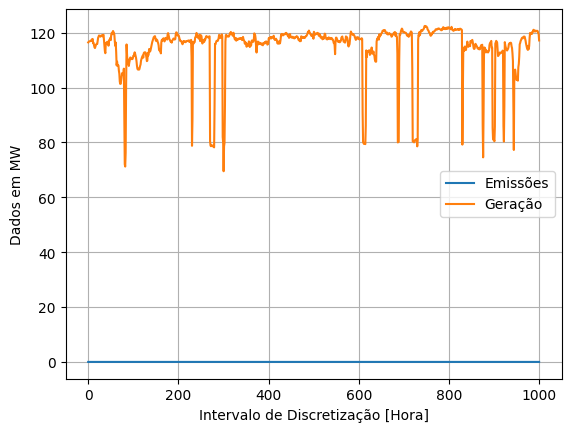

In [43]:
# Gráfico com um eixo Y

x_fig = np.linspace(0,len(y_test),len(x_test))
tempo_inicio = 0
tempo_fim = 1000

plt.figure()
plt.plot(x_fig[tempo_inicio:tempo_fim],y_test[tempo_inicio:tempo_fim], x_fig[tempo_inicio:tempo_fim],tab_trat['Geração'].loc[tab_trat['Usina'] == usina][tempo_inicio:tempo_fim])
plt.legend(['Emissões','Geração'])
plt.xlabel('Intervalo de Discretização [Hora]')
plt.ylabel('Dados em MW')
#plt.title(f'Regressão {usina} (MSE: {mse.result().numpy():.4f})')
plt.grid()
print(f'Regressão {usina} (MSRE: {msre.result().numpy():.4f})') if usina != '' else print('Regressão de todas as usinas')
plt.show()

Base

Gráfico referente à usina Aparecida



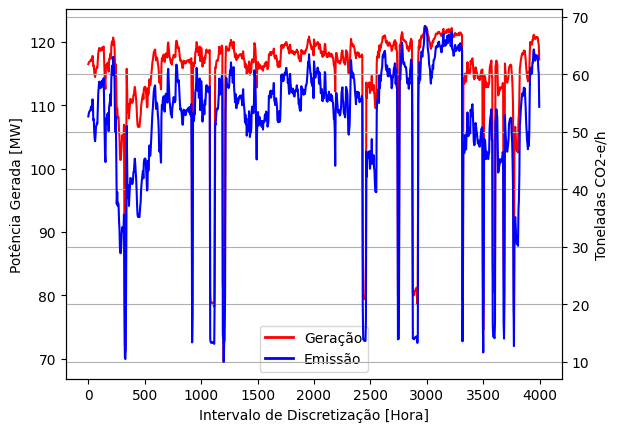

In [12]:
# Gráfico com dois eixos Y

x_fig = np.linspace(0,len(y_pred),len(x_test))
tempo_inicio = 0
tempo_fim = 1000

fig,ax1 = plt.subplots()

ax1.set_xlabel('Intervalo de Discretização [Hora]')
ax1.set_ylabel('Potência Gerada [MW]')
ax1.plot(x_fig[tempo_inicio:tempo_fim],tab_trat['Geração'].loc[tab_trat['Usina'] == usina][tempo_inicio:tempo_fim],color='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Toneladas CO2-e/h')
ax2.plot(x_fig[tempo_inicio:tempo_fim],y_pred[tempo_inicio:tempo_fim],color='b')
ax2.grid()

# Adicionando legendas personalizadas
legend_elements = [
    Line2D([0], [0], color='r', lw=2, label='Geração'),
    Line2D([0], [0], color='b', lw=2, label='Emissão')]

# Unindo as legendas
ax1.legend(handles=legend_elements, loc='best')

print(f'Gráfico referente à usina {usina}\n') if usina != '' else print('Gráfico referente à todas as usinas')
plt.show()

### Gráfico 3D

Base

In [ ]:
# Treino da Rede para Obter o Erro

neur_max = 20
z = np.array([])

dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'

if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
  print(f'Valores de erro para usina {usina} já existentes.')
else:
  for i in range(1, neur_max+1):
    print(f'Treinando para {i} neurônio(os) na primeira camada')

    for j in range(1, neur_max+1):
      K.clear_session()

      rede = tf.keras.Sequential()
      rede.add(tf.keras.layers.Dense(i,activation='relu'))
      rede.add(tf.keras.layers.Dense(j,activation='relu'))
      rede.add(tf.keras.layers.Dense(1))

      opt = tf.keras.optimizers.Adam(learning_rate=0.001)
      rede.compile(optimizer=opt, loss='mean_squared_error')

      # Inicializa a medição do erro quadrático médio MSE
      #msre = tf.keras.metrics.MeanSquaredError()
      msre = tf.keras.metrics.Mean()

      #Treinamento e teste da rede
      print(f'Treinando para {j} neurônio(os) na segunda camada')
      rede.fit(x_train,y_train,epochs=2000,verbose=0)
      y_pred = rede.predict(x_train)

      msre.update_state(y_train, y_pred)
      z = np.append(z,msre.result().numpy())
      print(f'Treinamento concluído. Erro: {msre.result().numpy():.2f}\n')

  np.savetxt(f'MSRE {usina} - Gráfico 3D.txt', z)
  print(f'Todos os valores de erro para usina {usina} salvos.')

Teste - Erro

In [13]:
# Treino da Rede para Obter o Erro

neur_max = 20
z = np.array([])

dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'

if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
    print(f'Valores de erro para usina {usina} já existentes.')
else:
    for i in range(1, neur_max+1):
        print(f'Treinando para {i} neurônio(os) na primeira camada')

        for j in range(1, neur_max+1):
            K.clear_session()

            rede = tf.keras.Sequential()
            rede.add(tf.keras.layers.Dense(i, activation='relu'))
            rede.add(tf.keras.layers.Dense(j, activation='relu'))
            rede.add(tf.keras.layers.Dense(1))

            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            
            # Função de perda personalizada para RMSE
            def root_mean_squared_error(y_true, y_pred):
                return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

            rede.compile(optimizer=opt, loss=root_mean_squared_error)

            # Inicializa a medição do erro quadrático médio MSE
            msre = tf.keras.metrics.Mean()

            # Treinamento e teste da rede
            print(f'Treinando para {j} neurônio(os) na segunda camada')
            rede.fit(x_train, y_train, epochs=2000, verbose=0)
            y_pred = rede.predict(x_train)

            msre.update_state(tf.sqrt(tf.reduce_mean(tf.square(y_train - y_pred))))
            z = np.append(z, msre.result().numpy())
            print(f'Treinamento concluído. Erro: {msre.result().numpy():.2f}\n')

    np.savetxt(f'MSRE {usina} - Gráfico 3D.txt', z)
    print(f'Todos os valores de erro para usina {usina} salvos.')

Treinando para 1 neurônio(os) na primeira camada
Treinando para 1 neurônio(os) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


ValueError: Data must be 1-dimensional, got ndarray of shape (21043, 21043) instead

Teste 2 - Teste Completo

In [15]:

neur_max = 20 #20 neuronio
z = np.array([])

dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'

if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
    print(f'Valores de erro para usina {usina} já existentes.')
else:
    for i in range(1, neur_max + 1):
        print(f'Treinando para {i} neurônio(s) na primeira camada')

        for j in range(1, neur_max + 1):
            K.clear_session()

            # Definir a estrutura da rede neural
            rede = tf.keras.Sequential([
                tf.keras.layers.Dense(i, activation='relu', input_shape=(x_train.shape[1],)),
                tf.keras.layers.Dense(j, activation='relu'),
                tf.keras.layers.Dense(1)
            ])

            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            rede.compile(optimizer=opt, loss='mean_squared_error')

            # Inicializa a medição do erro quadrático médio MSE
            msre = tf.keras.metrics.Mean()

            # Treinamento e teste da rede
            print(f'Treinando para {j} neurônio(s) na segunda camada')
            rede.fit(x_train, y_train, epochs=100, verbose=0)  # Reduzir o número de épocas para acelerar

            y_pred = rede.predict(x_train)

            # Calcula MSRE
            y_train_flat = np.ravel(y_train)
            y_pred_flat = np.ravel(y_pred)
            relative_errors = np.abs((y_train_flat - y_pred_flat) / y_train_flat)
            squared_relative_errors = np.square(relative_errors)
            msre_value = np.mean(squared_relative_errors)

            z = np.append(z, msre_value)
            print(f'Treinamento concluído. Erro: {msre_value:.2f}\n')

    np.savetxt(f'{dir}\\MSRE {usina} - Gráfico 3D.txt', z)
    print(f'Todos os valores de erro para usina {usina} salvos.')

# Gráfico 3D relacionando erro pela quantidade de neurônios
x = np.array([i + 1 for i in range(neur_max) for _ in range(neur_max)])
y = np.array([j + 1 for _ in range(neur_max) for j in range(neur_max)])

if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
    z = np.loadtxt(f'{dir}\\MSRE {usina} - Gráfico 3D.txt')

    cm = 1 / 2.54
    fig = plt.figure(figsize=(20 * cm, 20 * cm))
    ax = fig.add_subplot(111, projection='3d')

    # Plotando pontos
    ax.scatter(x, y, z, c='r', marker='o')

    # Plotando faces
    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, color='cyan', edgecolors='k')

    # Mudando o passo dos eixos
    ax.set_xticks(np.arange(0, 21, 2))  # Define os ticks do eixo x
    ax.set_yticks(np.arange(0, 21, 2))  # Define os ticks do eixo y

    # Configurações adicionais
    ax.set_xlabel('Neurônios na 1ª Camada Oculta', fontsize=12)
    ax.set_ylabel('Neurônios na 2ª Camada Oculta', fontsize=12)
    ax.set_zlabel('Erro', fontsize=12, rotation=90)

    plt.show()
else:
    print(f'Erros para usina {usina} não gerados')

Treinando para 1 neurônio(s) na primeira camada


c:\Users\Yuri_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Treinando para 1 neurônio(s) na segunda camada


KeyboardInterrupt: 

Gráfico 3d e Rede Completo

Treinando para 1 neurônio(s) na primeira camada
Treinando para 1 neurônio(s) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Treinamento concluído. Erro: 37.21

Treinando para 2 neurônio(s) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Treinamento concluído. Erro: 37.21

Treinando para 3 neurônio(s) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Treinamento concluído. Erro: 1.20

Treinando para 2 neurônio(s) na primeira camada
Treinando para 1 neurônio(s) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Treinamento concluído. Erro: 37.22

Treinando para 2 neurônio(s) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Treinamento concluído. Erro: 37.22

Treinando para 3 neurônio(s) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Treinamento concluído. Erro: 37.21

Treinando para 3 neurônio(s) na primeira camada
Treinando para 1 neurônio(s) na segunda camada
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Treinamento concluído. Er

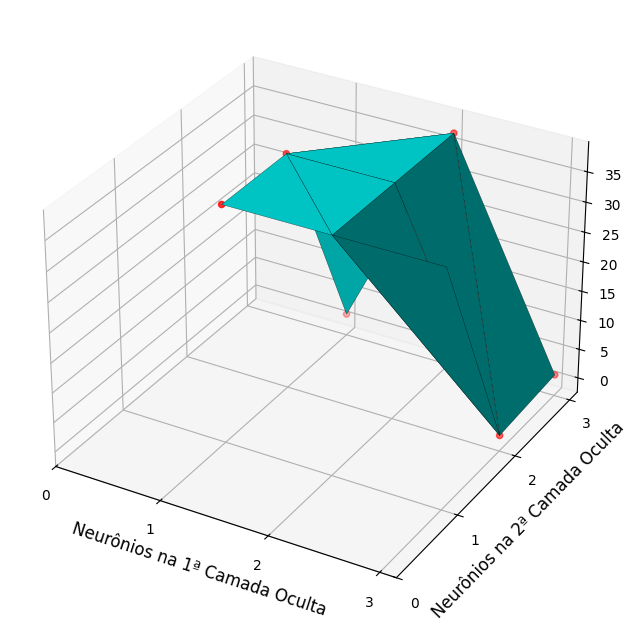

In [17]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow.keras.backend as K

neur_max = 3  # Limitar para no máximo 3 neurônios a 20
z = np.array([])

dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
usina = 'Nome_da_Usina'  # Certifique-se de definir o nome da usina



if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
    print(f'Valores de erro para usina {usina} já existentes.')
else:
    for i in range(1, neur_max + 1):
        print(f'Treinando para {i} neurônio(s) na primeira camada')

        for j in range(1, neur_max + 1):  # Limitar a segunda camada a no máximo 2 neurônios
            K.clear_session()

            # Definir a estrutura da rede neural
            rede = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(x_train.shape[1],)),
                tf.keras.layers.Dense(i, activation='relu'),
                tf.keras.layers.Dense(j, activation='relu'),
                tf.keras.layers.Dense(1)
            ])

            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            rede.compile(optimizer=opt, loss='mean_squared_error')

            # Inicializa a medição do erro quadrático médio MSE
            msre = tf.keras.metrics.Mean()

            # Treinamento e teste da rede
            print(f'Treinando para {j} neurônio(s) na segunda camada')
            rede.fit(x_train, y_train, epochs=200, verbose=0)  # Reduzir o número de épocas para acelerar /2000

            y_pred = rede.predict(x_train)

            # Calcula MSRE
            y_train_flat = np.ravel(y_train)
            y_pred_flat = np.ravel(y_pred)
            relative_errors = np.abs((y_train_flat - y_pred_flat) / y_train_flat)
            squared_relative_errors = np.square(relative_errors)
            msre_value = np.mean(squared_relative_errors)

            z = np.append(z, msre_value)
            print(f'Treinamento concluído. Erro: {msre_value:.2f}\n')

    np.savetxt(f'{dir}\\MSRE {usina} - Gráfico 3D.txt', z)
    print(f'Todos os valores de erro para usina {usina} salvos.')

# Gráfico 3D relacionando erro pela quantidade de neurônios
x = np.array([i + 1 for i in range(neur_max) for _ in range(neur_max)])
y = np.array([j + 1 for _ in range(neur_max) for j in range(neur_max)])

if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
    z = np.loadtxt(f'{dir}\\MSRE {usina} - Gráfico 3D.txt')

    cm = 1 / 2.54
    fig = plt.figure(figsize=(20 * cm, 20 * cm))
    ax = fig.add_subplot(111, projection='3d')

    # Plotando pontos
    ax.scatter(x, y, z, c='r', marker='o')

    # Plotando faces
    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, color='cyan', edgecolors='k')

    # Mudando o passo dos eixos
    ax.set_xticks(np.arange(0, neur_max + 1, 1))  # Define os ticks do eixo x
    ax.set_yticks(np.arange(0, neur_max + 1, 1))  # Define os ticks do eixo y

    # Configurações adicionais
    ax.set_xlabel('Neurônios na 1ª Camada Oculta', fontsize=12)
    ax.set_ylabel('Neurônios na 2ª Camada Oculta', fontsize=12)
    ax.set_zlabel('Erro', fontsize=12, rotation=90)

    plt.show()
else:
    print(f'Erros para usina {usina} não gerados')

Teste 2

In [ ]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow.keras.backend as K

neur_max = 20  # Você pode ajustar este valor para testar diferentes configurações
z = np.array([])

dir = 'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
usina = 'Nome_da_Usina'  # Certifique-se de definir o nome da usina


if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
    print(f'Valores de erro para usina {usina} já existentes.')
else:
    for i in [2, 4, 8, 12, 16, 20]:  # Tente diferentes números de neurônios
        print(f'Treinando para {i} neurônio(s) na primeira camada')

        for j in range(1, 3):  # Limitar a segunda camada a no máximo 2 neurônios / ate 20
            K.clear_session()

            # Definir a estrutura da rede neural
            rede = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(x_train.shape[1],)),
                tf.keras.layers.Dense(i, activation='relu'),
                tf.keras.layers.Dense(j, activation='relu'),
                tf.keras.layers.Dense(1)
            ])

            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            rede.compile(optimizer=opt, loss='mean_squared_error')

            # Inicializa a medição do erro quadrático médio MSE
            msre = tf.keras.metrics.Mean()

            # Treinamento e teste da rede
            print(f'Treinando para {j} neurônio(s) na segunda camada')
            rede.fit(x_train, y_train, epochs=500, verbose=0)  # Reduzir o número de épocas para acelerar /epoch 2000

            y_pred = rede.predict(x_train)

            # Calcula MSRE
            y_train_flat = np.ravel(y_train)
            y_pred_flat = np.ravel(y_pred)
            relative_errors = np.abs((y_train_flat - y_pred_flat) / y_train_flat)
            squared_relative_errors = np.square(relative_errors)
            msre_value = np.mean(squared_relative_errors)

            z = np.append(z, msre_value)
            print(f'Treinamento concluído. Erro: {msre_value:.2f}\n')

    np.savetxt(f'{dir}\\MSRE {usina} - Gráfico 3D.txt', z)
    print(f'Todos os valores de erro para usina {usina} salvos.')

# Gráfico 3D relacionando erro pela quantidade de neurônios
x = np.array([i for i in [2, 4, 8, 12, 16, 20] for _ in range(2)])
y = np.array([j + 1 for _ in range(6) for j in range(2)])

if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):
    z = np.loadtxt(f'{dir}\\MSRE {usina} - Gráfico 3D.txt')

    cm = 1 / 2.54
    fig = plt.figure(figsize=(20 * cm, 20 * cm))
    ax = fig.add_subplot(111, projection='3d')

    # Plotando pontos
    ax.scatter(x, y, z, c='r', marker='o')

    # Plotando faces
    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, color='cyan', edgecolors='k')

    # Mudando o passo dos eixos
    ax.set_xticks(np.array([2, 4, 8, 12, 16, 20]))  # Define os ticks do eixo x
    ax.set_yticks(np.arange(0, 3, 1))  # Define os ticks do eixo y

    # Configurações adicionais
    ax.set_xlabel('Neurônios na 1ª Camada Oculta', fontsize=12)
    ax.set_ylabel('Neurônios na 2ª Camada Oculta', fontsize=12)
    ax.set_zlabel('Erro', fontsize=12, rotation=90)

    plt.show()
else:
    print(f'Erros para usina {usina} não gerados')

Base 2

In [11]:
# Gráfico 3D relacionando erro pela quantia de neurônios

x = np.array([])
for i in range(neur_max):
  for j in range(neur_max):
    x = np.append(x,i+1)

y = np.array([])
for i in range(neur_max):
  for j in range(neur_max):
    y = np.append(y,j+1)

dir = f'G:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'

if os.path.isfile(f'{dir}\\MSRE {usina} - Gráfico 3D.txt'):

  z = np.loadtxt(f'MSRE {usina} - Gráfico 3D.txt')

  cm = 1/2.54
  fig = plt.figure(figsize=(20*cm,20*cm))
  ax = fig.add_subplot(111, projection='3d')

  # Plotando pontos
  ax.scatter(x, y, z, c='r', marker='o')

  # Plotando linhas (Opcional)
  # for i in range(len(x)):
  #     ax.plot([x[i], x[i]], [y[i], y[i]], [0, z[i]], color='b')

  # Plotando faces
  ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, color='cyan',edgecolors='k')

  # Mudando o passo dos eixos
  ax.set_xticks(np.arange(0, 21, 2))  # Define os ticks do eixo x
  ax.set_yticks(np.arange(0, 21, 2))  # Define os ticks do eixo y
  #ax.set_zticks(np.arange(0, 1))  # Define os ticks do eixo z

  # Configurações adicionais
  ax.set_xlabel('Neurônios na 1ª Camada Oculta', fontsize=12)
  ax.set_ylabel('Neurônios na 2ª Camada Oculta', fontsize=12)
  ax.set_zlabel('Erro', fontsize=12,rotation=90)

  plt.show()

else:
  print(f'Erros para usina {usina} não gerados')